# 1. Introduction and Data Loading
The first step in developing our (s, S) inventory policy simulation is to understand and model the stochastic components of the system. This notebook analyzes the provided dataset to determine the underlying distributions for demand inter-arrival time and demand quantity.

1.1. Setup and Data Import
First, we import the necessary libraries and load the dataset.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare the dataset
file_path = "inventory_data.xlsx"
df = pd.read_excel(file_path)
df = df.set_index('Demand No.')
inter_arrival = df['Time elapsed since the arrival of last demand'].dropna().astype(float)
demand_qty = df['Demand quantity'].dropna().astype(int)

# Display initial data summary
print("------------------------------ Data Summary ------------------------------")
df.describe()

------------------------------ Data Summary ------------------------------


,Time elapsed since the arrival of last demand,Demand quantity
count,5000.000000,5000.000000
mean,0.101765,4.779400
std,0.101870,2.567344
min,0.000000,1.000000
25%,0.029108,2.000000
50%,0.070954,6.000000
75%,0.139175,7.000000
max,0.939156,8.000000


# 2. Analysis of Inter-Arrival Time
We hypothesize that the time between consecutive customer demands follows an Exponential distribution, which is characteristic of a Poisson arrival process.

## 2.1. Statistical Fitting and Testing

We will fit an exponential distribution to the data and use the Kolmogorov-Smirnov (K-S) test to assess the goodness of fit. The null hypothesis (H_0) is that the data is drawn from an exponential distribution.

In [42]:
# --- Verification for Inter-arrival Time (Hypothesis: Exponential) ---

print("--- Verifying Inter-arrival Time as Exponential ---")

# 1. Fit the exponential distribution to the data (fix loc=0 for inter-arrival times)
loc_exp, scale_exp = st.expon.fit(inter_arrival, floc=0)
lambda_exp = 1 / scale_exp
print(f"Fitted Exponential parameters: location={loc_exp:.4f}, scale(1/λ)={scale_exp:.4f}, λ={lambda_exp:.4f}")

# 2. Kolmogorov-Smirnov (K-S) Test
ks_statistic, p_value = st.kstest(inter_arrival, 'expon', args=(loc_exp, scale_exp))
print(f"K-S Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value > 0.05:
    print("Conclusion: The data likely follows an Exponential distribution (fail to reject H0).")
else:
    print("Conclusion: The data does not follow an Exponential distribution (reject H0).")


Fitted Exponential parameters: location=0.0000, scale(1/λ)=0.1018, λ=9.8266

K-S Statistic: 0.0075
P-value: 0.9411

Conclusion: The data likely follows an Exponential distribution (fail to reject H0).


## 2.2. Visual Verification
Visual checks using a probability plot (Q-Q plot) and a histogram overlayed with the fitted probability density function (PDF) confirm the statistical test.

The histogram of the data aligns well with the fitted exponential PDF, and the points on the Q-Q plot fall closely along the 45-degree line. Both plots provide strong visual support for our conclusion.

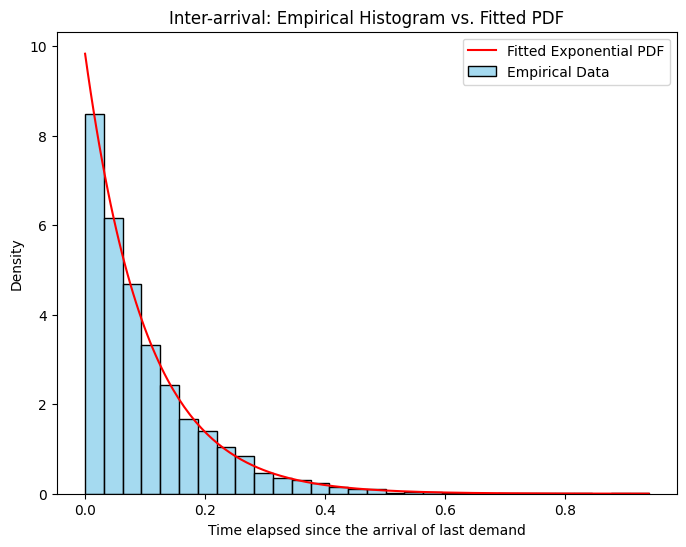

In [46]:
# Histogram vs Fitted PDF
plt.figure(figsize=(8, 6))
sns.histplot(inter_arrival, bins=30, kde=False, stat="density", label='Empirical Data', color="skyblue", edgecolor="black")
x_vals = np.linspace(inter_arrival.min(), inter_arrival.max(), 200)
pdf_fitted = st.expon.pdf(x_vals, loc=loc_exp, scale=scale_exp)
plt.plot(x_vals, pdf_fitted, 'r-', label='Fitted Exponential PDF')
plt.title('Inter-arrival: Empirical Histogram vs. Fitted PDF')
plt.legend()

<Figure size 800x600 with 0 Axes>

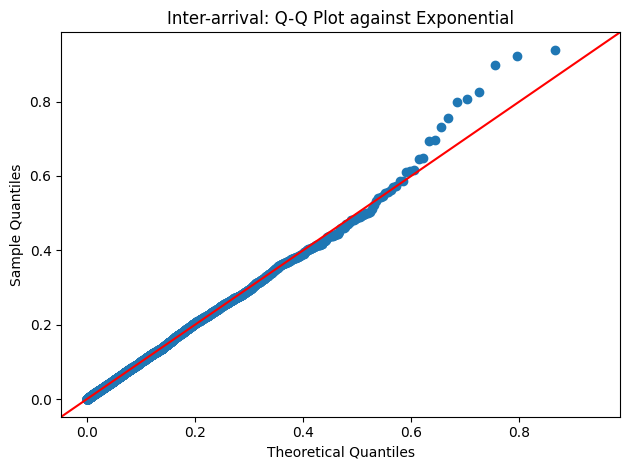

In [48]:
# Q-Q Plot
plt.figure(figsize=(8, 6))
sm.qqplot(inter_arrival, dist=st.expon, line='45', loc=loc_exp, scale=scale_exp)
plt.title('Inter-arrival: Q-Q Plot against Exponential')
plt.tight_layout()
plt.show()

## 2.3. Inter-Arrival Time Conclusion
The statistical and visual evidence strongly supports that the inter-arrival time follows an Exponential distribution with a rate
lambda
approx9.8266 demands per month.

# 3. Analysis of Demand Quantity
Next, we analyze the demand quantity per arrival. Since it's a discrete variable, we test it against several common discrete distributions.

## 3.1. Statistical Fitting and Testing
We test against the Poisson, Uniform, Lognormal, and Negative Binomial distributions. For discrete distributions, we use the Chi-square goodness of fit test. The null hypothesis (H_0) for each test is that the data follows the specified distribution.

In [49]:
# Helper function to scale expected frequencies for Chi-square test
def scale_expected(expected, observed_total):
    expected = np.array(expected)
    expected *= observed_total / expected.sum()
    return expected

# --- Test 1: Poisson Distribution ---
print("--- Poisson Fit ---")
mu = np.mean(demand_qty)
obs_freq, bins = np.histogram(demand_qty, bins=range(demand_qty.min(), demand_qty.max()+2))
expected_freq = [len(demand_qty) * st.poisson.pmf(k, mu) for k in range(demand_qty.min(), demand_qty.max()+1)]
chi2, p_val = st.chisquare(obs_freq, f_exp=scale_expected(expected_freq, obs_freq.sum()))
print(f"Chi-square: {chi2:.4f}, p-value: {p_val:.4e}")
if p_val > 0.05:
    print("Conclusion: The data could follow a Poisson distribution (fail to reject H0).")
else:
    print("Conclusion: The data does not follow a Poisson distribution (reject H0).")

# --- Test 2: Uniform Distribution ---
print("\n--- Uniform Fit ---")
a, b = demand_qty.min(), demand_qty.max()
expected_freq = [len(demand_qty) * (1.0/(b-a+1)) for _ in range(a, b+1)]
chi2, p_val = st.chisquare(obs_freq, f_exp=scale_expected(expected_freq, obs_freq.sum()))
print(f"Chi-square: {chi2:.4f}, p-value: {p_val:.4e}")
if p_val > 0.05:
    print("Conclusion: The data could follow a Uniform distribution (fail to reject H0).")
else:
    print("Conclusion: The data does not follow a Uniform distribution (reject H0).")

# --- Test 3: Lognormal Distribution (using K-S as it's a continuous fit) ---
print("\n--- Lognormal Fit ---")
shape, loc, scale = st.lognorm.fit(demand_qty, floc=0)
ks_stat, p_val = st.kstest(demand_qty, 'lognorm', args=(shape, loc, scale))
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_val:.4e}")
if p_val > 0.05:
    print("Conclusion: The data could follow a Lognormal distribution (fail to reject H0).")
else:
    print("Conclusion: The data does not follow a Lognormal distribution (reject H0).")

# --- Test 4: Negative Binomial Distribution ---
print("\n--- Negative Binomial Fit ---")
mean_d, var_d = np.mean(demand_qty), np.var(demand_qty)
if var_d > mean_d:  # Condition for Negative Binomial (overdispersion)
    # Method of moments estimators for r and p
    r = mean_d**2 / (var_d - mean_d)
    p = r / (r + mean_d)
    expected_freq = [len(demand_qty) * st.nbinom.pmf(k, r, p) for k in range(demand_qty.min(), demand_qty.max()+1)]
    chi2, p_val = st.chisquare(obs_freq, f_exp=scale_expected(expected_freq, obs_freq.sum()))
    print(f"Estimated r = {r:.4f}, p = {p:.4f}")
    print(f"Chi-square: {chi2:.4f}, p-value: {p_val:.4e}")
    if p_val > 0.05:
        print("Conclusion: The data could follow a Negative Binomial distribution (fail to reject H0).")
    else:
        print("Conclusion: The data does not follow a Negative Binomial distribution (reject H0).")
else:
    print("Negative Binomial not applicable as variance is not greater than the mean.")

--- Poisson Fit ---
Chi-square: 5403.6607, p-value: 0.0000e+00
Conclusion: The data does not follow a Poisson distribution (reject H0).

--- Uniform Fit ---
Chi-square: 1115.9264, p-value: 1.0630e-236
Conclusion: The data does not follow a Uniform distribution (reject H0).

--- Lognormal Fit ---
KS Statistic: 0.2461, p-value: 3.1416e-267
Conclusion: The data does not follow a Lognormal distribution (reject H0).

--- Negative Binomial Fit ---
Estimated r = 12.6165, p = 0.7253
Chi-square: 3709.1518, p-value: 0.0000e+00
Conclusion: The data does not follow a Negative Binomial distribution (reject H0).


## 3.2. Visual Verification
The p-values for all tests are effectively zero, leading us to reject the null hypothesis in every case. A visual comparison confirms the poor fit of these theoretical distributions.

The plot clearly shows that none of the candidate distributions accurately capture the shape of the empirical data histogram.

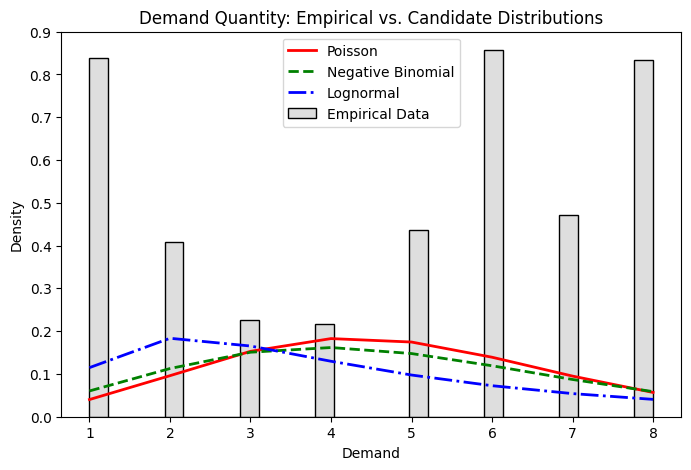

In [51]:
# === Empirical vs Fitted PDFs ===
plt.figure(figsize=(8,5))
sns.histplot(demand_qty, bins=30, stat="density", kde=False,
             color="lightgray", label="Empirical Data")

x_vals = np.arange(demand_qty.min(), demand_qty.max()+1)

# Poisson
plt.plot(x_vals, poisson.pmf(x_vals, mu), 'r-', lw=2, label="Poisson")

# Negative Binomial
if var_d > mean_d:
    plt.plot(x_vals, nbinom.pmf(x_vals, r, p), 'g--', lw=2, label="Negative Binomial")

# Lognormal
pdf_lognorm = lognorm.pdf(x_vals, shape, loc, scale)
plt.plot(x_vals, pdf_lognorm, 'b-.', lw=2, label="Lognormal")

plt.title("Demand Quantity: Empirical vs. Candidate Distributions")
plt.xlabel("Demand")
plt.ylabel("Density")
plt.legend()
plt.show()

## 3.3. Demand Quantity Conclusion
The demand quantity data does not follow any of the standard theoretical distributions we tested.

# 4. Final Conclusion & Simulation Strategy
Based on our analysis, we will model the system's random components as follows:

Inter-Arrival Time: We will generate the time between demands by sampling from an Exponential distribution with a rate parameter
lambda=9.8266.

Demand Quantity: Since no standard distribution fits the data well, we will use an Empirical Distribution. In the simulation, when a demand event occurs, we will generate the demand size by randomly sampling with replacement from the original 5,000 data points provided.